Цель:

Спрогнозировать значение Global_active_power на 1–24 часа вперёд по данным за прошлые сутки.

План:

- Загрузим и очистим данные

- Обучим LightGBM

- Сделаем предсказание на следующий день

In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Электропотребление

In [ ]:
# Загрузка
df = pd.read_csv("household_power_consumption.txt", sep=';', low_memory=False, na_values='?')

# Парсинг даты
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df.set_index('Datetime', inplace=True)

In [ ]:
# Преобразование целевой переменной
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df[['Global_active_power']].resample('H').mean().dropna()

# Признаки
for lag in range(1, 25):
    df[f'lag_{lag}'] = df['Global_active_power'].shift(lag)

df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['rolling_mean_24'] = df['Global_active_power'].rolling(24).mean()

df = df.dropna()

<ipython-input-16-a39c7e9d9f35>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df[['Global_active_power']].resample('H').mean().dropna()


In [ ]:
len(df)

34144

In [ ]:
0.005 * len(df)

170.72

In [ ]:
# Разделение
X = df.drop('Global_active_power', axis=1)
y = df['Global_active_power']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.0025)

# Обучение
model = LGBMRegressor()
model.fit(X_train, y_train)

# Прогноз
y_pred = model.predict(X_test)

# Оценка
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6419
[LightGBM] [Info] Number of data points in the train set: 34058, number of used features: 28
[LightGBM] [Info] Start training from score 1.090535
RMSE: 0.3765


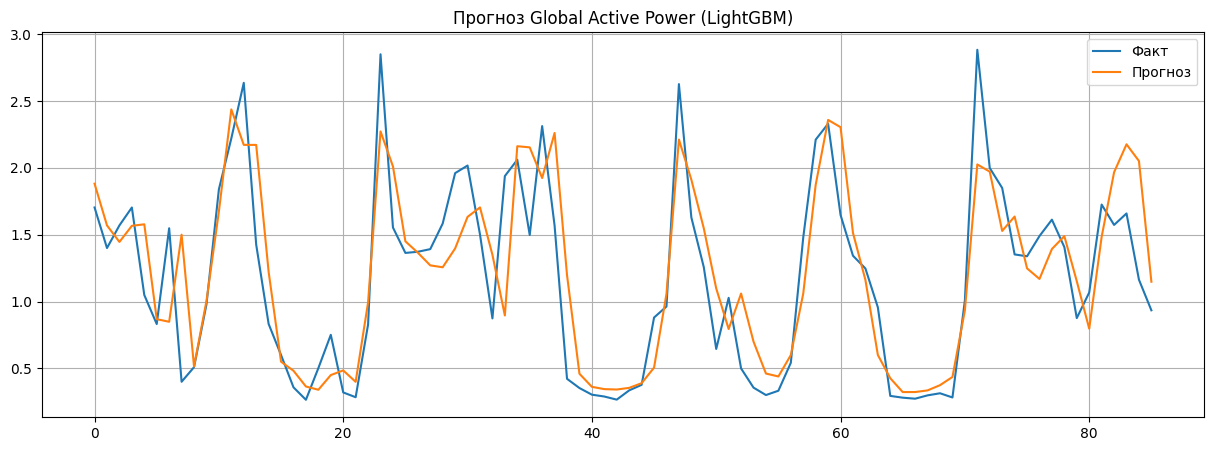

In [ ]:
# График
plt.figure(figsize=(15, 5))
plt.plot(y_test.values, label="Факт")
plt.plot(y_pred, label="Прогноз")
plt.legend()
plt.title("Прогноз Global Active Power (LightGBM)")
plt.grid(True)
plt.show()

# Финансовые данные

In [ ]:
import lightgbm as lgb

In [ ]:
# Загрузка данных

df = pd.read_json("sber (1).json")

# Обработка данных

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['dayofweek'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

# Подготовка признаков

features = ['open', 'low', 'high', 'trendclspr', 'volume', 'value', 'numtrades', 'dayofweek', 'month']
target = 'close'

In [ ]:
# Разделение на выборки train/test

train_df = df[:-5]
test_df = df[-5:]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

In [ ]:
# Обучение

model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1798
[LightGBM] [Info] Number of data points in the train set: 1061, number of used features: 9
[LightGBM] [Info] Start training from score 229.172365


LGBMRegressor(random_state=42)

In [ ]:
# Прогноз

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Оценка

print(f"RMSE: {rmse:.4f}")

RMSE: 1.0109


In [ ]:
# Визуализация

result_df = test_df[['date']].copy()
result_df['actual_close'] = y_test.values
result_df['predicted_close'] = y_pred
result_df['error'] = result_df['predicted_close'] - result_df['actual_close']

print(result_df)

           date  actual_close  predicted_close     error
1061 2025-03-21        323.26       324.016304  0.756304
1062 2025-03-24        319.47       318.834921 -0.635079
1063 2025-03-25        319.80       320.438096  0.638096
1064 2025-03-26        315.23       316.154007  0.924007
1065 2025-03-27        311.96       313.655145  1.695145


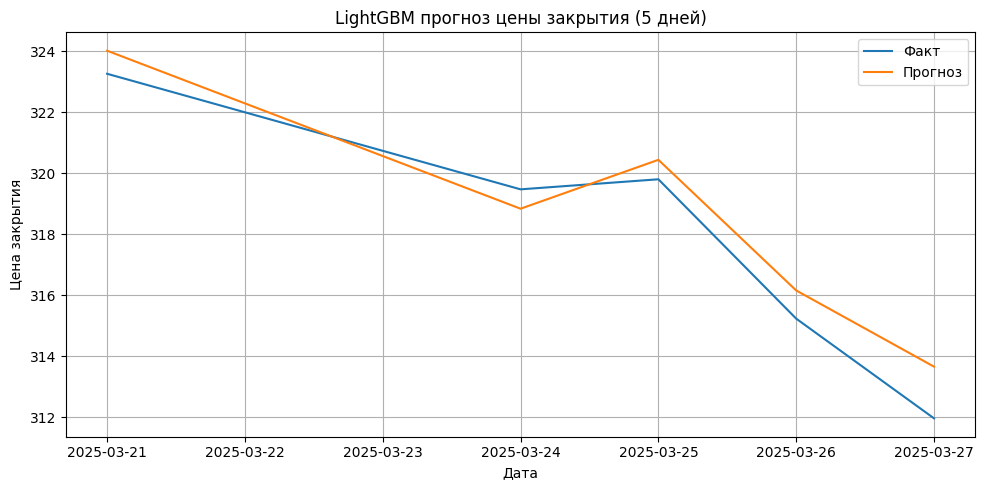

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(result_df['date'], result_df['actual_close'], label='Факт')
plt.plot(result_df['date'], result_df['predicted_close'], label='Прогноз')
plt.title('LightGBM прогноз цены закрытия (5 дней)')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()